Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `~/Documents/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

┌ Info: Precompiling KPpack [26ea0ef3-e7b0-494e-b39b-84c42b7463c6]
└ @ Base loading.jl:1342


# Create a KP model

In [3]:
using Symbolics, LinearAlgebra
using PyCall, PyPlot

In [4]:
#read Hamiltonian created in createHam.ipynb 
dirHam="/home/martinez/Documents/repos/kp-lflm-group/Models_Hamiltonian/";name="kane6x6"

Htot=KPpack.readHamiltonian(dirHam,name)

strK=["k_x","k_y","k_z"];
Emomentum=KPpack.setMomentum(strK);
HVar=KPpack.getVar(Htot)

9-element Vector{Num}:
 VBO
   c
 g_1
 g_2
 k_y
 k_z
 k_x
 g_3
   Δ

In [5]:
real(Htot)

6×6 Matrix{Num}:
 VBO - c*(g_1 - 2g_2)*(k_y^2 + k_z^2) - c*(g_1 + 4g_2)*(k_x^2)          …                                                              0.333333Δ
                                               -6c*g_3*k_x*k_y                                                                         0
                                               -6c*g_3*k_x*k_z                                                                         0
                                                             0                                                           -6c*g_3*k_x*k_z
                                                             0                                                           -6c*g_3*k_y*k_z
                                                             0.333333Δ  …  VBO - c*(g_1 + 4g_2)*(k_z^2) - c*(g_1 - 2g_2)*(k_x^2 + k_y^2)

In [6]:
var=Emomentum[3] 
H0,H1,H2=KPpack.createKm(Htot,var);
#p=HVar[13];
p=HVar[1]; kind="nonSymm"
H1l,H1r=KPpack.createH1Corr(H1,p, Emomentum,kind);

## test the bulk calculation

In [7]:
material="GaAs"; Temp=10; soc=true; opt="calc"
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp,opt);
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [8]:
kmax= 1.4; Nt=200; consth=0.038; const2=sqrt(consth)
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,Htot,Emomentum,consth,const2)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

In [9]:
mm.Eg+mm.VBO

0.718747196261682

# Plot band diagram

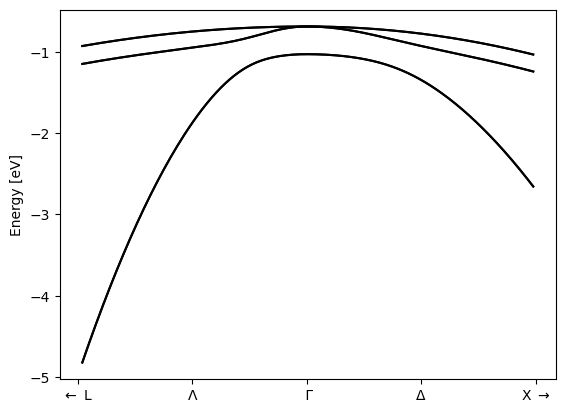

In [10]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

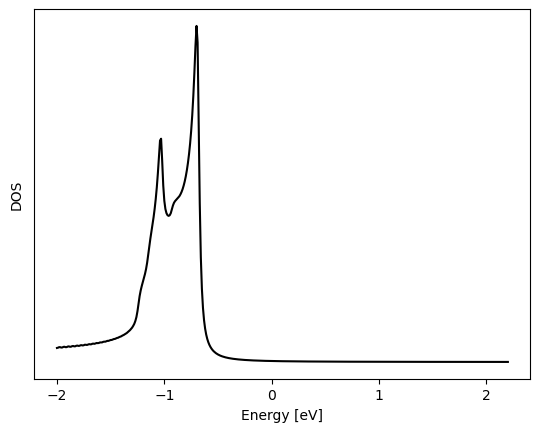

In [11]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [12]:
structure=["AlGaAs_1.0" "5";
    "AlGaAs_1.0" "5";
    "GaAs" "5";
    "AlGaAs_1.0" "5";
    "AlGaAs_1.0" "5";]

#structure=["AlGaAs_0.2" "10";
#    "GaAs" "3";
#    "AlGaAs_0.2" "10";]

Npts,layer,nlayer=KPpack.setStructure(structure,0.26,Temp)

X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp,opt);
Npts

24

# Plot structure

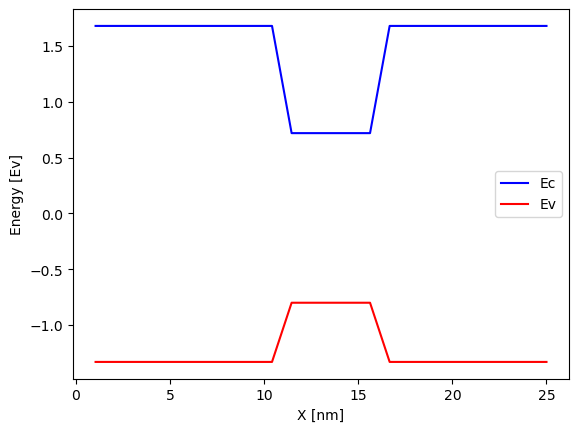

In [13]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

  4.949341 seconds (7.93 M allocations: 471.972 MiB, 4.48% gc time, 99.24% compilation time)


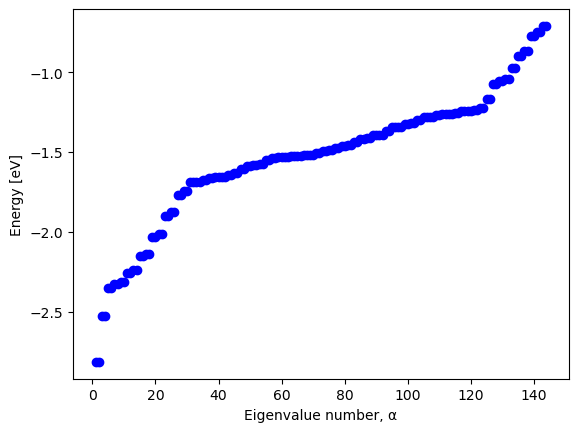

In [14]:
c=0.038; cps=sqrt(c); dx=X[2]-X[1];  cr=0.9; s=0.6; pb=true; siz=size(H0)[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,H0,H1l,H1r,H2,c,cps,dx,Emomentum,pb,cr,s);
KPpack.PloteigvQW(Npts,Eqw0,siz);


# QW Band Structure Calculation

In [15]:
kmax= 0.9; Nt=100;
nc=1; nv=6

sV,sC,pos=KPpack.eigenValQW(real(Eqw0),siz)
#sV=-0.6; sC=-0.1
pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax+0.1,Nt,dx,pl,pm,Npts,H0,H1l,H1r,H2,nc,nv,c,cps,sV,sC,Emomentum,pb,cr,s);

  7.922626 seconds (10.60 M allocations: 826.770 MiB, 12.22% gc time, 59.64% compilation time)
  2.678105 seconds (3.47 M allocations: 390.890 MiB, 3.19% gc time)


## Valence Band 

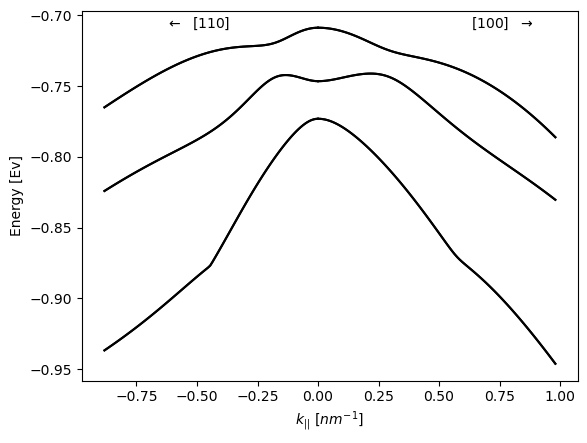

In [16]:
option="complete_V"; poslab=sV
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

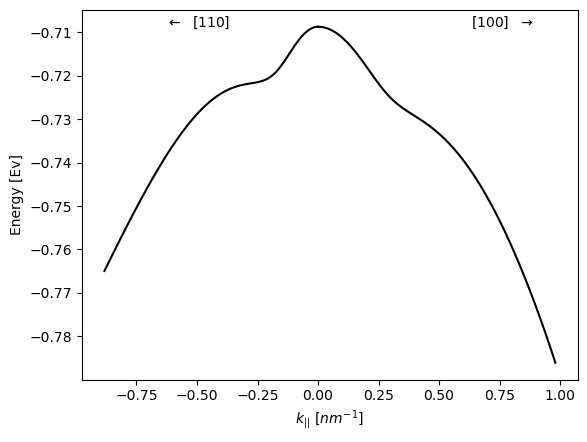

In [17]:
option="complete_C"; poslab=sC
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

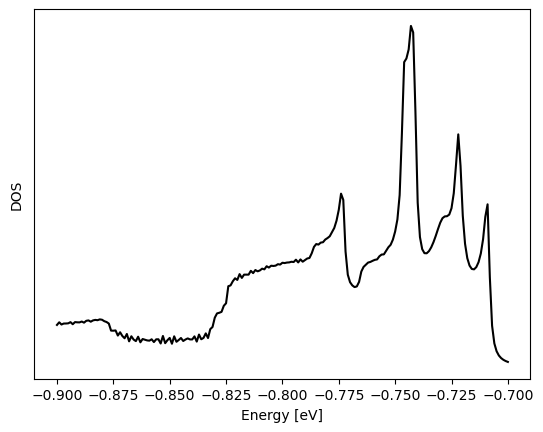

In [18]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.9,-0.7,0.001,Evqw,2e-3);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

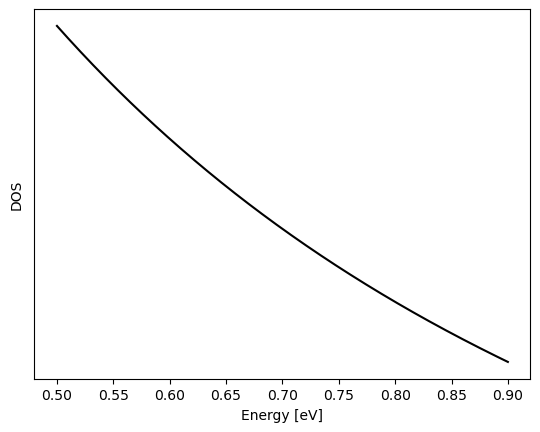

In [19]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.5,0.9,0.001,Evqw,1e-2);
KPpack.PlotDOS(EDOSc,aDOSc);

In [20]:
kx,ky=0.1,0.1
hns=KPpack.FDHamiltonian(H0,H1l,H1r,H2,mlayer,kx,ky,dx,c,cps,Npts,Emomentum,pb,cr,s)

144×144 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 1104 stored entries:
⣻⢞⣣⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⣤
⠉⢾⡿⢏⢷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠈⠙⢳⡟⢍⣻⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠛⠾⣱⣾⠷⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠹⢧⣕⣽⠶⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠘⣧⣱⢞⣣⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢾⡟⢍⢷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢳⣟⢝⣺⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠚⢾⣱⣾⠧⣆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠩⢧⣟⣽⢿⣠⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⣳⣱⢞⣳⡆⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⠾⡟⣭⢷⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⣷⣟⢝⣧⣄⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢿⡱⣮⠷⣀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢣⣿⣿⢻⡄⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠛⠶⣵⢟⡳⣆⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠹⢮⡟⣭⣶⣤⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⣿⣛⢜⣧⣄⡀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢿⡑⣬⠷⣀
⠛⣤⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠙⢣⣿⢟

In [21]:
hns-hns'

144×144 SparseArrays.SparseMatrixCSC{ComplexF64, Int64} with 0 stored entries:
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

## =====================================================|

In [22]:
boundPoints

4-element Vector{Float64}:
  5.0
 10.0
 15.0
 20.0

In [23]:
Npts

24

In [24]:
i=21
kx,ky=0.0,0.0

H0Re,H0Im=KPpack.createFuncFD(H0,Emomentum); H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum)
H2Re,H2Im=KPpack.createFuncFD(H2,Emomentum);
    
H2n=KPpack.evalFuncFD(H2Re,H2Im,mlayer,i,kx,ky,c,cps,cr,s,siz)

mA=KPpack.createFDAmatrix(mlayer,i,H0Re,H0Im,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz); 
mB=KPpack.createFDBmatrix(mlayer,i+1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz);
mC=KPpack.createFDCmatrix(mlayer,i-1,H1rRe,H1rIm,H1lRe,H1lIm,H2Re,H2Im,kx,ky,dx,c,cps,cr,s,siz);
mlayer[i].material

"AlGaAs_1.0"

In [25]:
size(mA)[1]

6

In [26]:
EigH2=eigvals(H2n)

6-element Vector{Float64}:
 0.08056
 0.08056
 0.08056
 0.08056
 0.26752
 0.26752

In [27]:
eigneg=0; eigpos=0

for i in 1:length(EigH2)
    if EigH2[i] <= 0
        eigneg += EigH2[i]
    else
        eigpos += EigH2[i]
    end
end

abs(eigneg/eigpos)

0.0

save a file with band structure

In [28]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

## create a Finite differences matrices

# =======================================================

In [29]:
i=20; s=0.6
kx,ky=0.0,0.0
cps=0.38
H1Re,H1Im=KPpack.createFuncFD(H1,Emomentum);

H1n=KPpack.evalFuncFD(H1Re,H1Im,mlayer,i,kx,ky,c,cps,cr,s,siz)
H1n

6×6 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

In [30]:
H1rRe,H1rIm=KPpack.createFuncFD(H1r,Emomentum); H1lRe,H1lIm=KPpack.createFuncFD(H1l,Emomentum);

H1rn=KPpack.evalFuncFD(H1rRe,H1rIm,mlayer,i,kx,ky,c,cps,cr,s,siz); H1ln=KPpack.evalFuncFD(H1lRe,H1lIm,mlayer,i,kx,ky,c,cps,cr,s,siz)
H1ln

6×6 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im  0.0+0.0im

# ================================

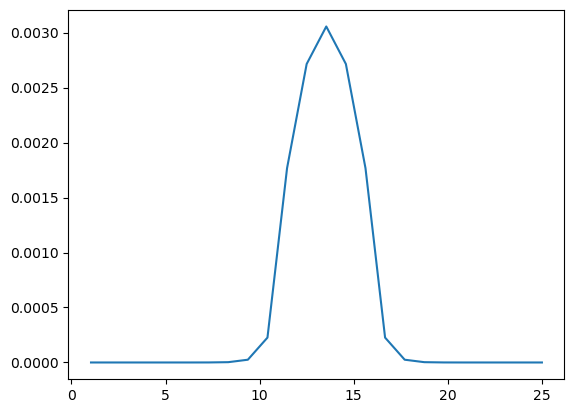

-0.7086951554886509

In [31]:
i=pos-0


Evec=EVqw0[1:siz:end,i]

#vv=Evec.*transpose(Evec')
vv=abs.(Evec)
#vv=Evec
#lt.xlim(150,250)
plt.plot(X,real(vv))
Eqw0[i]

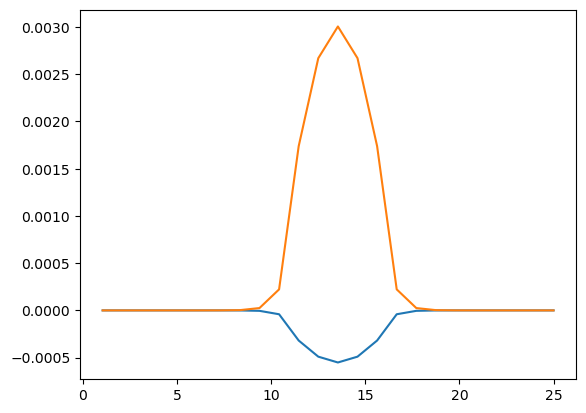

In [32]:
plt.plot(X,real(Evec))
plt.plot(X,imag(Evec));

# ======================================================

# Surfaces of valence band quantum Well

In [33]:
kinic,kend=-1.0,1.0; kstep=0.1
@time EArr=KPpack.eigenSurface(H0,H1r,H1l,H2,mlayer,dx,c,cp,Npts,Emomentum,pb,cr,s,sV,nv,kinic,kend,kstep);

 26.313293 seconds (36.23 M allocations: 2.273 GiB, 2.88% gc time, 4.83% compilation time)


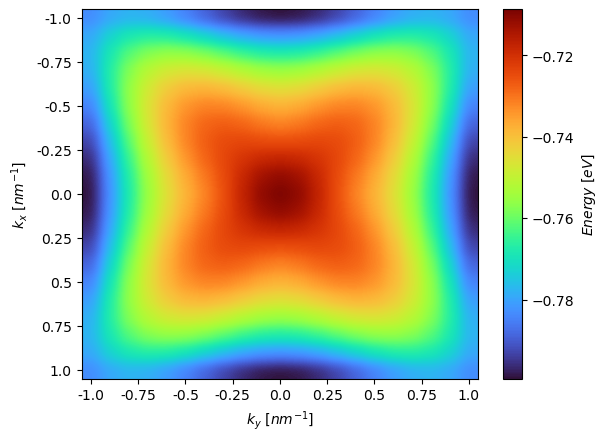

In [34]:
KPpack.plotEigSurface(EArr,1,kinic,kend)

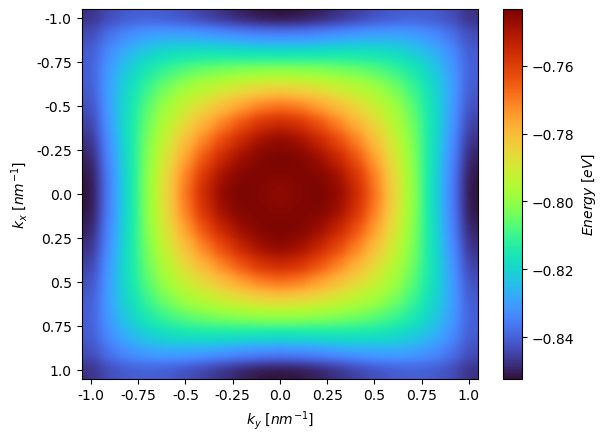

In [35]:
KPpack.plotEigSurface(EArr,3,kinic,kend)

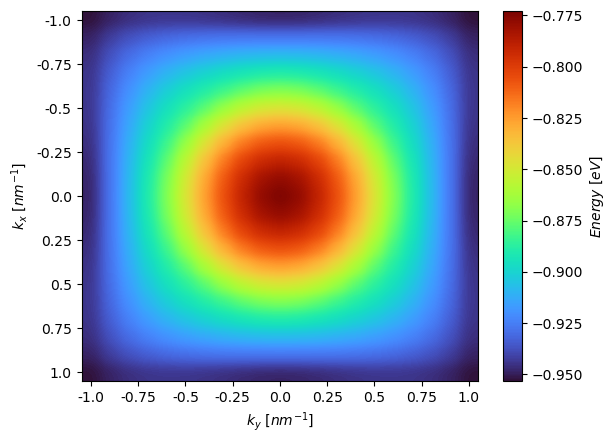

In [36]:
KPpack.plotEigSurface(EArr,5,kinic,kend)